In [1]:
import os
import glob

# Third-party
from astropy.io import fits, ascii
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline
import h5py

In [2]:
# contains the label information
meta_tbl = ascii.read("../data/training_dr13e2_large_cleaner_H_fix_lower_dr13.list")
meta_tbl.rename_column('col1', 'url')
meta_tbl.rename_column('col2', 'Teff')
meta_tbl.rename_column('col3', 'logg')
meta_tbl.rename_column('col4', '[Fe/H]')
meta_tbl.rename_column('col5', '[alpha/Fe]')
meta_tbl['filename'] = [os.path.basename(x) for x in meta_tbl['url']]

In [3]:
spec_style = dict(marker='', drawstyle='steps-mid', color='k', alpha=0.04)

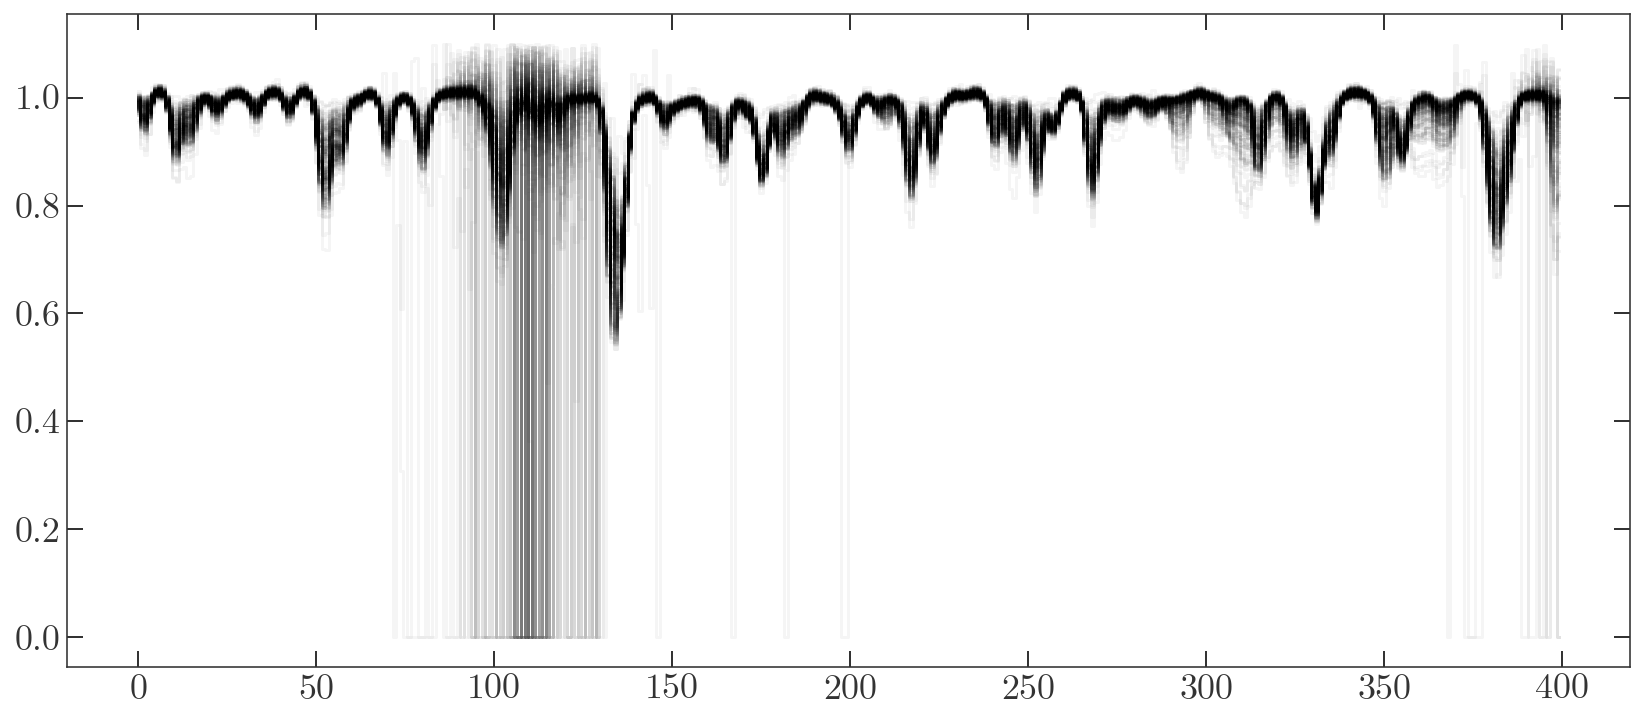

In [4]:
plt.figure(figsize=(14,6))

for i,fn in enumerate(glob.glob("../data/spectra/*.fits")):
    hdu = fits.open(fn)[1]
    flux = hdu.data

    plt.plot(flux[1000:1400], **spec_style)
    if i > 256:
        break

In [40]:
n_pixels = len(flux)
label_names = ['Teff', 'logg', '[Fe/H]', '[alpha/Fe]']
n_labels = len(label_names)
n_sample = 4096

In [41]:
X = np.zeros((n_sample, n_pixels))
y = np.zeros((n_sample, n_labels))
filenames = []

In [44]:
for i,fn in enumerate(glob.glob("../data/spectra/*.fits")):
    hdu = fits.open(fn)[1]
    flux = hdu.data
    row = meta_tbl[meta_tbl['filename'] == os.path.basename(fn)][label_names].as_array()
    
    X[i] = flux
    y[i] = row.view(np.float64).reshape(row.shape + (-1,))[0] # OMG: why
    filenames.append(os.path.basename(fn))
    
    if i >= (n_sample-1):
        break

In [11]:
# Sort on [Fe/H]
idx = np.argsort(y[:,2])

In [12]:
X[X==0] = np.nan

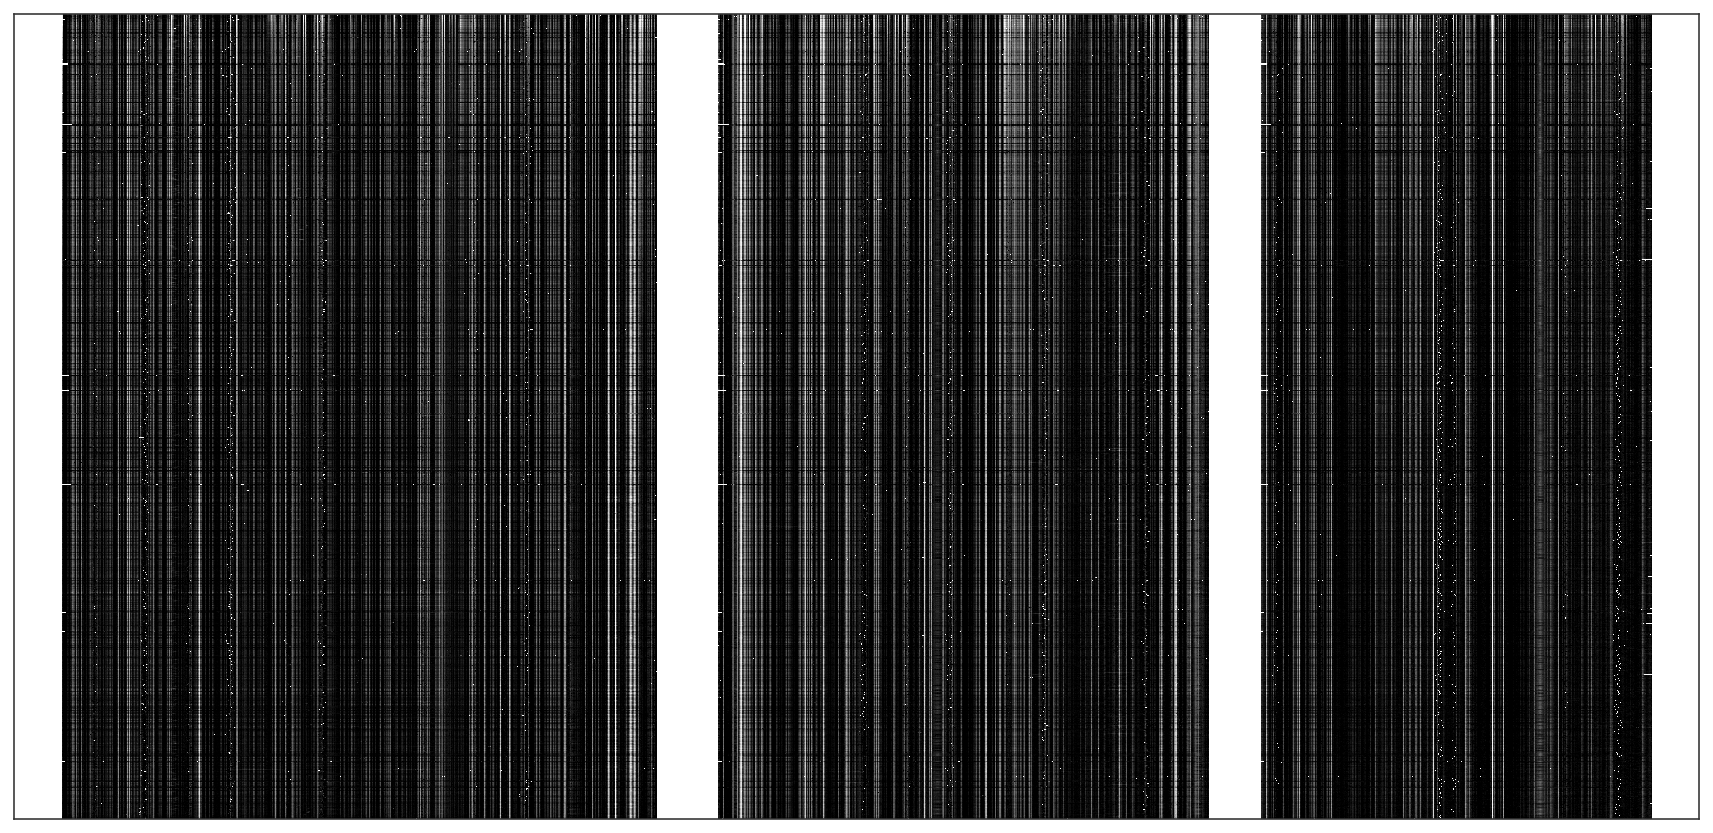

In [15]:
fig,ax = plt.subplots(1,1,figsize=(12, 6))
ax.imshow(X[idx], cmap='Greys', vmin=0.6, vmax=1.)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()
fig.savefig('../plots/spectra2d.png', dpi=400)

In [18]:
np.array(filenames).astype('S44')

array([b'aspcapStar-r6-l30e.2-2M00002005+5703467.fits',
       b'aspcapStar-r6-l30e.2-2M00002504+1517108.fits',
       b'aspcapStar-r6-l30e.2-2M00003157+7059085.fits', ...,
       b'aspcapStar-r6-l30e.2-2M19501796+4802596.fits',
       b'aspcapStar-r6-l30e.2-2M19502672+4625332.fits',
       b'aspcapStar-r6-l30e.2-2M19502805+4727199.fits'], 
      dtype='|S44')

In [45]:
y.shape

(4096, 4)

In [46]:
with h5py.File('../data/apogee-spectra.h5', 'w') as f:
    f['X'] = X
    
    for i,name in enumerate(label_names):
        f[name] = y[:,i]
    f['filenames'] = np.array(filenames).astype('S44')

In [10]:
with h5py.File('../data/apogee-spectra.h5', 'r') as f:
    X = f['X'][:]
    y = f['y'][:]